In [ ]:
from scipy import sparse
from sklearn import linear_model
from collections import Counter
import numpy as np
import operator
import nltk
import math
from scipy.stats import norm
import pandas as pd

!wget https://raw.githubusercontent.com/dbamman/nlp22/main/HW3/glove.6B.50d.50K.txt

--2022-04-23 04:45:55--  https://raw.githubusercontent.com/dbamman/nlp22/main/HW3/glove.6B.50d.50K.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21357789 (20M) [text/plain]
Saving to: ‘glove.6B.50d.50K.txt.3’

glove.6B.50d.50K.tx 100%[===================>]  20.37M  --.-KB/s    in 0.1s    

2022-04-23 04:45:55 (152 MB/s) - ‘glove.6B.50d.50K.txt.3’ saved [21357789/21357789]



In [ ]:
!python -m nltk.downloader punkt

/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def load_ordinal_data(filename, ordering):
    X = []
    Y = []
    orig_Y=[]
    for ordinal in ordering:
        Y.append([])
        
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols = line.split("\t")
            idd = cols[0]
            label = cols[1].lstrip().rstrip()
            text = cols[2]

            X.append(text)
            
            index=ordering.index(label)
            for i in range(len(ordering)):
                if index > i:
                    Y[i].append(1)
                else:
                    Y[i].append(0)
            orig_Y.append(label)
                    
    return X, Y, orig_Y



In [ ]:
class OrdinalClassifier:

    def __init__(self, ordinal_values, feature_method, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY):
        self.ordinal_values=ordinal_values
        self.feature_vocab = {}
        self.feature_method = feature_method
        self.min_feature_count=2
        self.log_regs = [None]* (len(self.ordinal_values)-1)

        self.trainY=trainY
        self.devY=devY
        self.testY=testY
        
        self.orig_trainY=orig_trainY
        self.orig_devY=orig_devY
        self.orig_testY=orig_testY
        
        self.trainX = self.process(trainX, training=True)
        self.devX = self.process(devX, training=False)
        self.testX = self.process(testX, training=False)

    # Featurize entire dataset
    def featurize(self, data):
        featurized_data = []
        for text in data:
            feats = self.feature_method(text)
            featurized_data.append(feats)
        return featurized_data

    # Read dataset and returned featurized representation as sparse matrix + label array
    def process(self, X_data, training = False):
        
        data = self.featurize(X_data)

        if training:
            fid = 0
            feature_doc_count = Counter()
            for feats in data:
                for feat in feats:
                    feature_doc_count[feat]+= 1

            for feat in feature_doc_count:
                if feature_doc_count[feat] >= self.min_feature_count:
                    self.feature_vocab[feat] = fid
                    fid += 1

        F = len(self.feature_vocab)
        D = len(data)
        X = sparse.dok_matrix((D, F))
        for idx, feats in enumerate(data):
            for feat in feats:
                if feat in self.feature_vocab:
                    X[idx, self.feature_vocab[feat]] = feats[feat]

        return X


    def train(self):
        (D,F) = self.trainX.shape

        
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            best_dev_accuracy=0
            best_model=None
            for C in [0.1, 1, 10, 100]:

                log_reg = linear_model.LogisticRegression(C = C, max_iter=1000)
                log_reg.fit(self.trainX, self.trainY[idx])
                development_accuracy = log_reg.score(self.devX, self.devY[idx])
                if development_accuracy > best_dev_accuracy:
                    best_dev_accuracy=development_accuracy
                    best_model=log_reg


            self.log_regs[idx]=best_model
        
    def test(self):
        cor=tot=0
        counts=Counter()
        preds=[None]*(len(self.ordinal_values)-1)
        for idx, ordinal_value in enumerate(self.ordinal_values[:-1]):
            preds[idx]=self.log_regs[idx].predict_proba(self.testX)[:,1]
        
        preds=np.array(preds)
        predY = []
            
        for data_point in range(len(preds[0])):
            
    
            ordinal_preds=np.zeros(len(self.ordinal_values))
            for ordinal in range(len(self.ordinal_values)-1):
                if ordinal == 0:
                    ordinal_preds[ordinal]=1-preds[ordinal][data_point]
                else:
                    ordinal_preds[ordinal]=preds[ordinal-1][data_point]-preds[ordinal][data_point]

            ordinal_preds[len(self.ordinal_values)-1]=preds[len(preds)-1][data_point]

            prediction=np.argmax(ordinal_preds)
            predY.append(str(prediction + 1))
            counts[prediction]+=1
            if prediction == self.ordinal_values.index(self.orig_testY[data_point]):
                cor+=1
            tot+=1

        return cor/tot, predY

In [ ]:
PAD_INDEX = 0             # reserved for padding words
UNKNOWN_INDEX = 1         # reserved for unknown words
SEP_INDEX = 2

data_lens = []

def read_embeddings(filename, vocab_size=50000):

  # get the embedding size from the first embedding
  with open(filename, encoding="utf-8") as file:
    word_embedding_dim = len(file.readline().split(" ")) - 1

  vocab = {}

  embeddings = np.zeros((vocab_size, word_embedding_dim))
  with open(filename, encoding="utf-8") as file:
    for idx, line in enumerate(file):

      if idx + 2 >= vocab_size:
        break

      cols = line.rstrip().split(" ")
      val = np.array(cols[1:])
      word = cols[0]
      embeddings[idx + 2] = val
      vocab[word] = idx + 2
  
  return embeddings, vocab

In [ ]:
def glove_featurize(text):
    embs, glove_vocab = read_embeddings("glove.6B.50d.50K.txt")
    feats = {}

    words=nltk.word_tokenize(text)
    avg_emb=np.zeros(50)
    avg_counter = 0.
    for word in words:
        word=word.lower()
        if word in glove_vocab:
            avg_emb += embs[glove_vocab[word]]
            avg_counter += 1
    avg_emb /= avg_counter

    for i in range(len(avg_emb)):
        feats[i] = avg_emb[i]
    
    print(feats)
    return feats

In [ ]:
def binary_bow_featurize(text):
    feats = {}
    words = nltk.word_tokenize(text)

    for word in words:
        word=word.lower()
        feats[word]=1
            
    return feats

In [ ]:
def confidence_intervals(accuracy, n, significance_level):
    critical_value=(1-significance_level)/2
    z_alpha=-1*norm.ppf(critical_value)
    se=math.sqrt((accuracy*(1-accuracy))/n)
    return accuracy-(se*z_alpha), accuracy+(se*z_alpha)

In [ ]:
def run(trainingFile, devFile, testFile, ordinal_values):


    trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
    devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
    testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)
    
    simple_classifier = OrdinalClassifier(ordinal_values, binary_bow_featurize, trainX, trainY, devX, devY, testX, testY, orig_trainY, orig_devY, orig_testY)
    simple_classifier.train()
    accuracy, predY = simple_classifier.test()

    lower, upper=confidence_intervals(accuracy, len(testY[0]), .95)
    print("Test accuracy for best dev model: %.3f, 95%% CIs: [%.3f %.3f]\n" % (accuracy, lower, upper))
    return predY

In [ ]:
# gid=2
trainingFile = "train.txt" 
devFile = "dev.txt" 
testFile = "test.txt" 
    
# ordinal values must be in order *as strings* from smallest to largest, e.g.:
# ordinal_values=["G", "PG", "PG-13", "R"]

ordinal_values=['1', '2', '3', '4', '5']

predY = run(trainingFile, devFile, testFile, ordinal_values)

Test accuracy for best dev model: 0.332, 95% CIs: [0.267 0.397]



In [ ]:
trainX, trainY, orig_trainY=load_ordinal_data(trainingFile, ordinal_values)
devX, devY, orig_devY=load_ordinal_data(devFile, ordinal_values)
testX, testY, orig_testY=load_ordinal_data(testFile, ordinal_values)

# **EDA/Data Vis**

<BarContainer object of 5 artists>

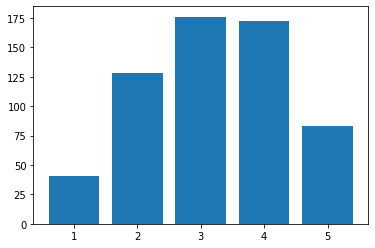

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.bar(ordinal_values, pd.Series(orig_trainY).value_counts().sort_index())


In [ ]:
np.mean([pred == orig for pred, orig in zip(predY, orig_testY)])

0.3316831683168317

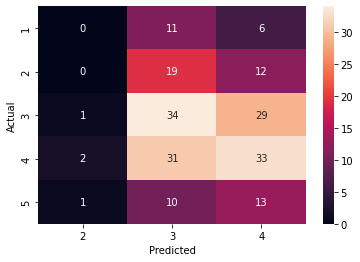

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual': orig_testY,
        'y_Predicted': predY
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()

## NBA Excitement Model Analysis:

The most predicted excitement score class was 3 (with 34 correctly predicted entries) since it had 105 total predictions (out of 202 predictions in the test dataset). The second-most predicted score of excitement was class 4 (with 33 correctly predicted entries), and that had 95 total predictions. Additionally, very few data points were predicted as 2 and none were correctly predicted as 2 as most entries that were actually of the score 2 were mostly assigned to scores of 3 and 4. 

One example of a systematic mistake that was introduced through our model from looking at our data’s confusion matrix was that the model did not predict an excitement score of 1 or 5 from the NBA game summary dataset. This is likely due to the class imbalance that is present (disportionately many of the scores were 2, 3, or 4). There is also a clear bias towards the excitement scores of 3 and 4 which are clearly predicted the most out of the 3 which generated predictions. When annotating our dataset, we found that a score of 1 or 5 as the extreme cases for excitement were not present compared to the other 3 categories which shows that there weren't enough data points for those categories for the model to accurately train the data. 

The precision and recall scores for classes 1, 2, and 5 were all 0% as expected (since our classifier never predicted those correctly), but the precision for classes 3 and 4 (32% and 35%) were middling, and recall scores higher (53% and 50%) since our classifier doesn’t care about false positives as much. 

We considered multiple methods in trying to get proper accuracy with our model. Featurization using glove embeddings yielded only a marginally better accuracy the the binary bag of words model, by 1.5% (34% accuracy overall), but this method ran much too slowly for us to continue optimizing; it took almost 30 minutes to featurize 1000 data points. We are not certain if this bottleneck is a result of our model design or inherent to glove embedding processing. 


In [ ]:
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('AP4_NBA.ipynb')

File ‘colab_pdf.py’ already there; not retrieving.





[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/AP4_NBA.ipynb to pdf
[NbConvertApp] Support files will be in AP4_NBA_files/
[NbConvertApp] Making directory ./AP4_NBA_files
[NbConvertApp] Making directory ./AP4_NBA_files
[NbConvertApp] Writing 53223 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
